In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg, controlrun
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1
time_sec_year=60*60*24*365
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return buffer

In [2]:
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')

In [3]:
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))

    #for i in range(maxlength):
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]

        data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig)
        dataout[i]=data
        F[i]=target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(data)):
                data[i]=data[i]+elevation
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig):
    
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=False)

        controlconfig=add_parameters(controlconfig,P,labels)
        #Vars.T,Vars.T_global=ZMT,GMT
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    
    if control==True:
        Vars.T,Vars.T_global=np.array([ZMT]*int(len(P)*2+1)),np.array([GMT]*int(len(P)*2+1))
    else:
        Vars.T,Vars.T_global=ZMT,GMT
        
    data=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        data_out=data[1][-1]
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
        
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [28]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
labels=[['func1','grey'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['func1','a'],['func1','b']]
P0=np.array([0.5,1.165,1.165,1.165])
P_pert=P0/1000
Pmin=np.array([0.4,0.9,0.9,0.9])
Pmax=np.array([0.6,1.3,1.3,1.3])
precision=1e-7
maxlength=int(10)
targetmode='ZMT'
target=ZMT_10
targetfunction='LeastSquare'
num_params=4
gamma0=1e-5
setup={'number_of_parameters': len(P0), 'number_of_cycles': 1, 'number_of_parallels': len(P0)*2+1}

config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat
control=False
controlconfig=0
#print(Vars.T)
#config,P0,P_pert,labels,maxlength,target,function,precision,num_paras,gamma0):
#builtins.number_of_integration=100
F, dF, P, Ptrans, gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
            maxlength,targetmode,target,targetfunction,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[2293.94911116 2139.73164626 2451.57351454 2292.20507601 2295.6944103
 2293.59605207 2294.30223314 2287.56929078 2300.34658738]
1e-05
[0.6        1.17553384 1.16713187 1.20357297]
Iteration no.1


[13442.92177502 13598.02800875 13288.83218452 13443.01182456
 13442.83171641 13442.9645013  13442.87904702 13443.63510236
 13442.20787778]
8.077243561601932e-07
[0.550051   1.17548992 1.16711103 1.20322495]
Iteration no.2


[2442.16322581 2508.76180777 2376.63767085 2442.3388532  2441.98761023
 2442.21697952 2442.1094737  2443.06533288 2441.26151685]
1.4104046888495265e-06
[0.5127813  1.17534037 1.16706526 1.20245692]
Iteration no.3


[163.24942139 141.19778951 187.01814637 162.98612317 163.51306534
 163.1794889  163.31937781 162.12352951 164.38155968]
1.047096205079896e-06
[0.52237696 1.17550694 1.16710948 1.20317069]
Iteration no.4


[81.21044747 95.55640585 68.4868943  81.28101354 81.14005386 81.22750134
 81.1934063  81.44779562 80.97634013]
6.584049392227632e-07
[0.51881242 1.17547892 1.1671027  1.20307699]
Iteration no.5


[23.24715876 25.56978607 23.30132478 23.21308072 23.28155122 23.23674908
 23.25759223 23.0732691  23.42739857]
7.183986602957473e-07
[0.51848649 1.17549377 1.16710722 1.20315379]
Iteration no.6


[22.99918256 23.77387781 24.57016736 22.95060076 23.04808299 22.98478732
 23.01360188 22.76133519 23.24344733]
5.291200182209234e-07
[0.51857076 1.17550934 1.16711182 1.2032308 ]
Iteration no.7


[22.94861122 24.13023789 24.1208403  22.90388654 22.99365335 22.93527718
 22.96196925 22.72779522 23.17582524]
5.303844586376846e-07
[0.51856976 1.17552371 1.1671161  1.20330253]
Iteration no.8


[22.93422649 24.11752824 24.1047784  22.88954532 22.97922505 22.92090517
 22.94757181 22.71362533 23.16122421]
3.8961219737872255e-06
[0.51855983 1.17562919 1.16714746 1.203829  ]
Iteration no.9


[1.00000000e-05 8.07724356e-07 1.41040469e-06 1.04709621e-06
 6.58404939e-07 7.18398660e-07 5.29120018e-07 5.30384459e-07
 3.89612197e-06 8.20414639e-04]


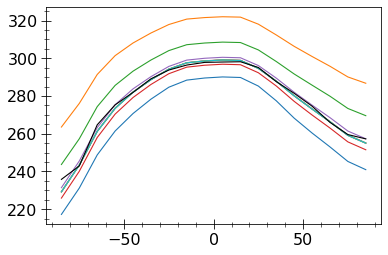

In [32]:
for i in range(10):
    plt.plot(Vars.Lat,data[i][0]+elevation)
#plt.plot(Vars.Lat,data[7][0])
plt.plot(Lat_10,ZMT_10,c='k')
print(gamma)

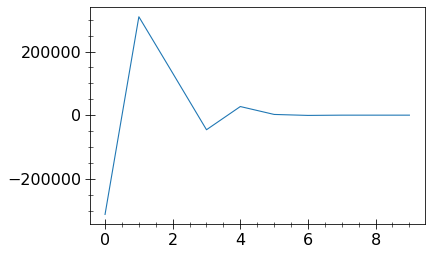

In [37]:
plt.plot(np.arange(10),dF[:,0])